# 🧠 RLHF Full Workflow (Unified Notebook)
This notebook trains PPO Expert, generates preference data using π₁ vs π₂, trains PPO-RLHF using RewardNet, and then trains a DPO policy — all within one integrated flow. Supports both discrete and continuous environments.

## 📦 Step 1: Setup and Imports

In [1]:
import os
import gymnasium as gym
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.policies import ActorCriticPolicy


## ⚙️ Step 2: Environment Setup

In [2]:
# ===== 🧩 Parameter Settings: Used to control the entire training / preference / visualization process =====

env_id = "CartPole-v1"     # Task environment name (Options: CartPole-v1, Pendulum-v1, Acrobot-v1, MountainCar-v0, MountainCarContinuous-v0)

seed = 42                  # Random seed to ensure experiment reproducibility

total_timesteps = 40_000   # Number of training steps for Expert PPO (Recommended: 30k for CartPole, 300k for Pendulum)

num_prefs = 200            # Number of preference samples
sample_prefs = 200

# ===========================================================


set_random_seed(seed)

env = Monitor(gym.make(env_id))
is_discrete = hasattr(env.action_space, "n")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
sample_length = 200
print(f"✅ Environment: {env_id} | Action space: {'Discrete' if is_discrete else 'Continuous'} | sample_length: {sample_length}")


✅ Environment: CartPole-v1 | Action space: Discrete | sample_length: 200


## 🧠 Step 3: Train PPO Expert (π₁) and Save Checkpoints

In [62]:
checkpoint_dir = f"./checkpoints_{env_id.replace('-', '_')}"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = CheckpointCallback(
    save_freq=total_timesteps // 10,
    save_path=checkpoint_dir,
    name_prefix="ppo"
)

expert_model = PPO("MlpPolicy", env, verbose=1, seed=seed)
expert_model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback)
expert_model.save(f"{env_id}_expert_seed{seed}.zip")
env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 22       |
| time/              |          |
|    fps             | 6665     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 24.6        |
|    ep_rew_mean          | 24.6        |
| time/                   |             |
|    fps                  | 4347        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008349772 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.2         |
|    entropy_loss   

## 🧪 Step 4: Select π₂ (Half-Performance PPO Checkpoint)

In [64]:
def evaluate_policy(model, env, episodes=10):
    scores = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        scores.append(total)
    return np.mean(scores)

env = gym.make(env_id)
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".zip")])
rewards = [(f, evaluate_policy(PPO.load(os.path.join(checkpoint_dir, f), env=env), env)) for f in checkpoints]
best_reward = max(rewards, key=lambda x: x[1])[1]
target = best_reward * 0.5
rewards.sort(key=lambda x: abs(x[1] - target))
pi2_model = PPO.load(os.path.join(checkpoint_dir, rewards[0][0]), env=env)
pi2_model.save(f"{env_id}_pi2_model_seed{seed}.zip")
print(f"✅ Selected π₂: {rewards[0][0]} with ~{rewards[0][1]:.1f} reward")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Selected π₂: ppo_16000_steps.zip with ~244.6 reward


## ❤️ Step 5: Generate Preferences (π₁ vs π₂)

In [65]:
import numpy as np
import pickle
from tqdm import trange
import numpy as np

def generate_trajectory(model, env, seed, max_steps):
    obs_list, act_list, rewards, mask = [], [], [], []
    obs, _ = env.reset()

    for step in range(max_steps):
        action, _ = model.predict(obs)
        obs_, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        obs_list.append(np.array(obs))       # ensure obs is np.array
        act_list.append(np.array(action))    # ensure action is np.array
        rewards.append(reward)
        mask.append(1)

        obs = obs_
        if done:
            break

    pad_len = max_steps - len(obs_list)
    if pad_len > 0:
        obs_shape = obs_list[0].shape
        obs_list += [np.zeros(obs_shape)] * pad_len
        act_shape = act_list[0].shape if isinstance(act_list[0], np.ndarray) else ()
        act_list += [np.zeros(act_shape)] * pad_len
        rewards += [0.0] * pad_len
        mask += [0] * pad_len

    return {
        "obs": np.stack(obs_list),       # [T, obs_dim]
        "acts": np.stack(act_list),      # [T] (discrete) or [T, act_dim] (continuous)
        "rews": np.stack(rewards),       # [T]
        "mask": np.stack(mask)           # [T]
    }

def compute_return(traj):
    return sum(traj["rews"])

def soft_preference_prob(R1, R2):
    max_r = max(R1, R2)
    return np.exp(R1 - max_r) / (np.exp(R1 - max_r) + np.exp(R2 - max_r))

# Sample preference data
prefs = []
for idx in trange(num_prefs, desc="🔄 Generating preference pairs"):
    traj1 = generate_trajectory(model = expert_model, env=env, seed=idx, max_steps=sample_length)
    traj2 = generate_trajectory(model = pi2_model, env=env, seed=idx, max_steps=sample_length)
    R1, R2 = compute_return(traj1), compute_return(traj2)
    p = soft_preference_prob(R1, R2)
    label = int(np.random.rand() < p)
    prefs.append((traj1, traj2, label))

# save .pkl
filename = f"prefs_{env_id}_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump(prefs, f)

print(f"✅ Saved {len(prefs)} preference pairs to {filename}")




🔄 Generating preference pairs: 100%|██████████| 200/200 [00:08<00:00, 24.90it/s]

✅ Saved 200 preference pairs to prefs_CartPole-v1_seed42.pkl


In [66]:
class PreferenceDataset(torch.utils.data.Dataset):
    def __init__(self, prefs, is_discrete):
        self.prefs = prefs
        self.is_discrete = is_discrete

    def __len__(self):
        return len(self.prefs)

    def __getitem__(self, idx):
        traj1, traj2, label = self.prefs[idx]

        return {
            "obs1": torch.from_numpy(traj1["obs"]).float(),
            "acts1": torch.from_numpy(traj1["acts"]).long() if self.is_discrete else torch.from_numpy(traj1["acts"]).float(),
            "mask1": torch.from_numpy(traj1["mask"]).float(),

            "obs2": torch.from_numpy(traj2["obs"]).float(),
            "acts2": torch.from_numpy(traj2["acts"]).long() if self.is_discrete else torch.from_numpy(traj2["acts"]).float(),
            "mask2": torch.from_numpy(traj2["mask"]).float(),

            "label": torch.tensor(label, dtype=torch.float32)
        }

## ⚙️ Step 7: Train DPO Policy

In [67]:
class SharedPolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete, hidden_size=64):
        super().__init__()
        self.is_discrete = is_discrete
        if is_discrete:
            self.net = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
        else:
            self.mu = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
            self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, obs):
        if self.is_discrete:
            return self.net(obs)
        else:
            mu = self.mu(obs)
            std = self.log_std.exp().expand_as(mu)
            return mu, std

    def select_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        if self.is_discrete:
            logits = self.forward(obs)
            probs = torch.softmax(logits, dim=-1)
            return probs.multinomial(num_samples=1).item()
        else:
            mu, std = self.forward(obs)
            dist = torch.distributions.Normal(mu, std)
            return dist.sample().squeeze(0).detach().numpy()


In [68]:
import torch.nn as nn
import copy


class SB3ActorOnly(nn.Module):
    def __init__(self, sb3_policy):
        super().__init__()
        self.features_extractor = copy.deepcopy(sb3_policy.features_extractor)
        self.mlp_extractor = copy.deepcopy(sb3_policy.mlp_extractor)
        self.action_net = copy.deepcopy(sb3_policy.action_net)

    def forward(self, obs):
        features = self.features_extractor(obs)
        latent_pi, _ = self.mlp_extractor(features)
        return self.action_net(latent_pi)



def init_shared_net_from_sb3(pi_model, shared_net):
    """
    Copy weights from a Stable Baselines3 PPO actor to a SharedPolicyNet instance.

    Args:
        pi2_model: A trained SB3 PPO model.
        shared_net: An instance of SharedPolicyNet with the same architecture.
    """
    sb_mlp = list(pi_model.policy.mlp_extractor.policy_net.children())
    sb_output = [pi_model.policy.action_net]
    sb_layers = [m for m in sb_mlp + sb_output if isinstance(m, nn.Linear)]

    shared_layers = [m for m in shared_net.net if isinstance(m, nn.Linear)]

    # Check layer count compatibility
    if len(sb_layers) != len(shared_layers):
        raise ValueError(f"Layer mismatch: SB3 has {len(sb_layers)} layers, "
                         f"SharedPolicyNet has {len(shared_layers)} layers.")

    # Copy weights and biases
    for sb_layer, shared_layer in zip(sb_layers, shared_layers):
        shared_layer.weight.data = sb_layer.weight.data.clone()
        shared_layer.bias.data = sb_layer.bias.data.clone()




In [102]:
import torch
import torch.nn.functional as F
from torch import nn
from stable_baselines3 import PPO

def train_dpo_from_ref(dataloader,ref_policy, env, beta= 0.05,  seed=42, epochs=200, device='cpu'):
    torch.manual_seed(seed)
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
    policy = SharedPolicyNet(obs_dim, act_dim, is_discrete).to(device)
    #we start from ref_policy
    init_shared_net_from_sb3(ref_policy, policy)
    ref_policy = SB3ActorOnly(ref_policy.policy).to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        policy.train()  # ensure in training mode
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            B, T = obs1.shape[0], obs1.shape[1]
            obs1_flat = obs1.view(-1, obs_dim) # [B*T, obs_dim]
            obs2_flat = obs2.view(-1, obs_dim) # [B*T, obs_dim]
            acts1_flat = acts1.view(-1).long() if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1).long() if is_discrete else acts2.view(-1, act_dim)

            # --- Compute log probs from trainable policy ---
            logp1 = torch.log_softmax(policy(obs1_flat), dim=-1)
            logp2 = torch.log_softmax(policy(obs2_flat), dim=-1)

            # --- Compute log probs from reference policy (frozen) ---
            with torch.no_grad():
                logp1_ref = torch.log_softmax(ref_policy(obs1_flat), dim=-1)
                logp2_ref = torch.log_softmax(ref_policy(obs2_flat), dim=-1)


            lp1 = (logp1 - logp1_ref)[torch.arange(len(acts1_flat)), acts1_flat].view(B, -1)
            lp2 = (logp2 - logp2_ref)[torch.arange(len(acts2_flat)), acts2_flat].view(B, -1)

            #lp1 = logp1[torch.arange(len(acts1_flat)), acts1_flat].view(B, -1)
            #lp2 = logp2[torch.arange(len(acts2_flat)), acts2_flat].view(B, -1)

            logp1_sum = (lp1 * mask1).sum(dim=1)  # [B]
            logp2_sum = (lp2 * mask2).sum(dim=1)  # [B]
            logits =beta*(logp1_sum - logp2_sum)        # [B]
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy


In [118]:
import torch
import torch.nn.functional as F
from torch import nn
from stable_baselines3 import PPO

def train_dpo(dataloader, env, seed=42, beta = 3, epochs=200, device='cpu'):
    torch.manual_seed(seed)
    is_discrete = hasattr(env.action_space, "n")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
    policy = SharedPolicyNet(obs_dim, act_dim, is_discrete).to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        policy.train()  # ensure in training mode
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            B, T = obs1.shape[0], obs1.shape[1]
            obs1_flat = obs1.view(-1, obs_dim) # [B*T, obs_dim]
            obs2_flat = obs2.view(-1, obs_dim) # [B*T, obs_dim]
            acts1_flat = acts1.view(-1).long() if is_discrete else acts1.view(-1, act_dim)
            acts2_flat = acts2.view(-1).long() if is_discrete else acts2.view(-1, act_dim)

            logp1 = torch.log_softmax(policy(obs1_flat), dim=-1)
            logp2 = torch.log_softmax(policy(obs2_flat), dim=-1)
            lp1 = logp1[torch.arange(len(acts1_flat)), acts1_flat].view(B, -1)
            lp2 = logp2[torch.arange(len(acts2_flat)), acts2_flat].view(B, -1)

            logp1_sum = (lp1 * mask1).sum(dim=1)  # [B]
            logp2_sum = (lp2 * mask2).sum(dim=1)  # [B]
            logits = beta * (logp1_sum - logp2_sum)        # [B]
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return policy

#with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
#    prefs = pickle.load(f)
#prefs = prefs[:200]
#
#dataset = PreferenceDataset(prefs, is_discrete)
#loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
#
#dpo_model = train_dpo(loader, env)
#torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")

Epoch 1/200, Loss: 36.6542
Epoch 2/200, Loss: 34.3266
Epoch 3/200, Loss: 33.3129
Epoch 4/200, Loss: 31.3952
Epoch 5/200, Loss: 31.0936
Epoch 6/200, Loss: 29.3756
Epoch 7/200, Loss: 29.6976
Epoch 8/200, Loss: 29.8448
Epoch 9/200, Loss: 29.1251
Epoch 10/200, Loss: 28.7009
Epoch 11/200, Loss: 27.3890
Epoch 12/200, Loss: 27.0970
Epoch 13/200, Loss: 27.4956
Epoch 14/200, Loss: 26.9489
Epoch 15/200, Loss: 27.6461
Epoch 16/200, Loss: 26.6486
Epoch 17/200, Loss: 27.4476
Epoch 18/200, Loss: 26.7515
Epoch 19/200, Loss: 26.2464
Epoch 20/200, Loss: 26.5822
Epoch 21/200, Loss: 25.0255
Epoch 22/200, Loss: 26.0768
Epoch 23/200, Loss: 24.5222
Epoch 24/200, Loss: 26.0771
Epoch 25/200, Loss: 25.3964
Epoch 26/200, Loss: 24.9186
Epoch 27/200, Loss: 24.3411
Epoch 28/200, Loss: 23.5361
Epoch 29/200, Loss: 24.2661
Epoch 30/200, Loss: 22.7768
Epoch 31/200, Loss: 22.7397
Epoch 32/200, Loss: 22.6871
Epoch 33/200, Loss: 22.4905
Epoch 34/200, Loss: 23.1330
Epoch 35/200, Loss: 23.8249
Epoch 36/200, Loss: 22.6334
E

Training DPO (π₂ → Expert) with β = 0.0
✅ SharedPolicyNet successfully initialized from SB3 PPO actor.
Epoch 1/100, Loss: 0.6931
Epoch 2/100, Loss: 0.6931
Epoch 3/100, Loss: 0.6931
Epoch 4/100, Loss: 0.6931
Epoch 5/100, Loss: 0.6931
Epoch 6/100, Loss: 0.6931
Epoch 7/100, Loss: 0.6931
Epoch 8/100, Loss: 0.6931
Epoch 9/100, Loss: 0.6931
Epoch 10/100, Loss: 0.6931
Epoch 11/100, Loss: 0.6931
Epoch 12/100, Loss: 0.6931
Epoch 13/100, Loss: 0.6931
Epoch 14/100, Loss: 0.6931
Epoch 15/100, Loss: 0.6931
Epoch 16/100, Loss: 0.6931
Epoch 17/100, Loss: 0.6931
Epoch 18/100, Loss: 0.6931
Epoch 19/100, Loss: 0.6931
Epoch 20/100, Loss: 0.6931
Epoch 21/100, Loss: 0.6931
Epoch 22/100, Loss: 0.6931
Epoch 23/100, Loss: 0.6931
Epoch 24/100, Loss: 0.6931
Epoch 25/100, Loss: 0.6931
Epoch 26/100, Loss: 0.6931
Epoch 27/100, Loss: 0.6931
Epoch 28/100, Loss: 0.6931
Epoch 29/100, Loss: 0.6931
Epoch 30/100, Loss: 0.6931
Epoch 31/100, Loss: 0.6931
Epoch 32/100, Loss: 0.6931
Epoch 33/100, Loss: 0.6931
Epoch 34/100, L

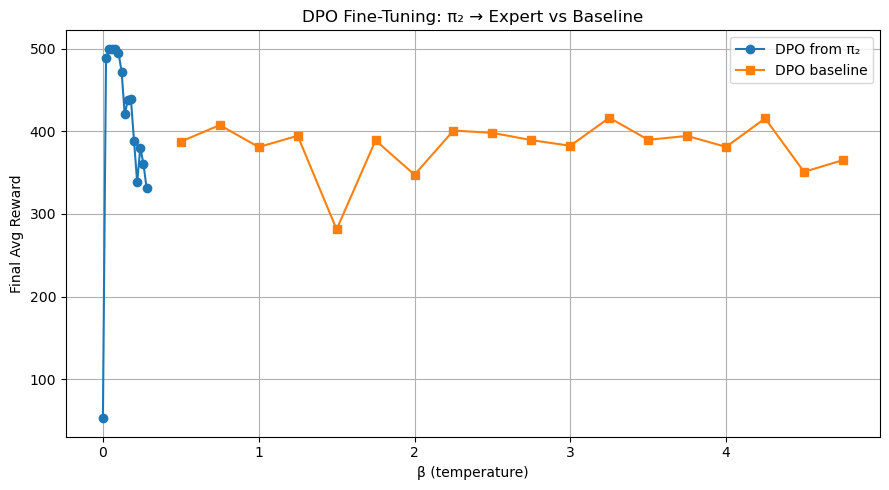

--------------------------------we use beta = 0.04
✅ SharedPolicyNet successfully initialized from SB3 PPO actor.
Epoch 1/200, Loss: 0.7723
Epoch 2/200, Loss: 0.7137
Epoch 3/200, Loss: 0.6607
Epoch 4/200, Loss: 0.6359
Epoch 5/200, Loss: 0.6352
Epoch 6/200, Loss: 0.6334
Epoch 7/200, Loss: 0.6261
Epoch 8/200, Loss: 0.6288
Epoch 9/200, Loss: 0.6312
Epoch 10/200, Loss: 0.6275
Epoch 11/200, Loss: 0.6184
Epoch 12/200, Loss: 0.6176
Epoch 13/200, Loss: 0.6130
Epoch 14/200, Loss: 0.6134
Epoch 15/200, Loss: 0.6166
Epoch 16/200, Loss: 0.6180
Epoch 17/200, Loss: 0.6048
Epoch 18/200, Loss: 0.6074
Epoch 19/200, Loss: 0.6104
Epoch 20/200, Loss: 0.6056
Epoch 21/200, Loss: 0.6093
Epoch 22/200, Loss: 0.6114
Epoch 23/200, Loss: 0.6009
Epoch 24/200, Loss: 0.6016
Epoch 25/200, Loss: 0.6078
Epoch 26/200, Loss: 0.5941
Epoch 27/200, Loss: 0.6030
Epoch 28/200, Loss: 0.5968
Epoch 29/200, Loss: 0.6067
Epoch 30/200, Loss: 0.5931
Epoch 31/200, Loss: 0.6026
Epoch 32/200, Loss: 0.5935
Epoch 33/200, Loss: 0.5934
Epoc

In [120]:
import matplotlib.pyplot as plt

def eval_policy(model, env, is_sb3=True, episodes=20):
    returns = []
    for idx in range(episodes):
        obs, _ = env.reset(seed=idx)
        total = 0.0
        done = False
        while not done:
            action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        returns.append(total)
    return returns



import matplotlib.pyplot as plt
import numpy as np

def fine_tune_dpo_with_betas(env, dataloader, pi2_model, beta_values_from_ref, beta_values, epochs=100, device='cpu'):
    rewards_from_ref = {}
    rewards = {}

    obs_dim = env.observation_space.shape[0]
    is_discrete = hasattr(env.action_space, "n")
    act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]

    # ✅ Train DPO starting from π₂ and moving toward expert
    for beta in beta_values_from_ref:
        print(f"Training DPO (π₂ → Expert) with β = {beta}")

        trained_policy_from_ref = train_dpo_from_ref(
            dataloader=dataloader,
            ref_policy=pi2_model,
            env=env,
            beta=beta,
            epochs=epochs,
            device=device
        )

        avg_reward = np.mean(eval_policy(trained_policy_from_ref, env, is_sb3=False, episodes=10))
        print(f"Final avg reward for β = {beta}: {avg_reward:.2f}")
        rewards_from_ref[beta] = avg_reward

    # ✅ Train regular DPO (e.g., random init or different reference)
    for beta in beta_values:
        print(f"Training DPO (scratch/init) with β = {beta}")

        trained_policy = train_dpo(
            dataloader=dataloader,
            env=env,
            beta=beta,
            epochs=epochs,
            device=device
        )

        avg_reward = np.mean(eval_policy(trained_policy, env, is_sb3=False, episodes=10))
        print(f"Final avg reward for β = {beta}: {avg_reward:.2f}")
        rewards[beta] = avg_reward

    # ✅ Plot both curves
    plt.figure(figsize=(9, 5))
    plt.plot(list(rewards_from_ref.keys()), list(rewards_from_ref.values()), marker='o', label="DPO from π₂")
    plt.plot(list(rewards.keys()), list(rewards.values()), marker='s', label="DPO baseline")
    plt.xlabel("β (temperature)")
    plt.ylabel("Final Avg Reward")
    plt.title("DPO Fine-Tuning: π₂ → Expert vs Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rewards_from_ref, rewards




with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:200]

dataset = PreferenceDataset(prefs, is_discrete)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

beta_values_from_ref = np.arange(0, 0.3, 0.02)
beta_values = np.arange(0.5, 5, 0.25)
#we could also potentially choose an adaptive beta, like : beta = beta_init * (epoch / max_epochs)

rewards_from_ref, rewards = fine_tune_dpo_with_betas(env, loader, pi2_model,beta_values_from_ref = beta_values_from_ref,beta_values=beta_values)

beta_from_ref = max(rewards_from_ref, key = rewards_from_ref.get)
print(f"--------------------------------we use beta = {beta_from_ref}")

dpo_model_from_ref = train_dpo_from_ref(loader,pi2_model, env, beta=beta_from_ref)
torch.save(dpo_model_from_ref.state_dict(), f"{env_id}_dpo_pi2_seed{seed}.pth")
beta = max(rewards, key = rewards.get)
dpo_model = train_dpo(loader, env, beta=beta)
torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")

## 🧠 Step 8: Train RewardNet from Preferences (for PPO-RLHF)

In [ ]:
class RewardNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete=True, hidden_size=64):
        super().__init__()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.is_discrete = is_discrete
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, states, actions):
        if self.is_discrete:
            one_hot = F.one_hot(actions.view(-1), num_classes=self.act_dim).float()
            x = torch.cat([states, one_hot], dim=-1)
        else:
            x = torch.cat([states, actions], dim=-1)
        return self.net(x).squeeze(-1)

def train_reward_model(dataloader, obs_dim, act_dim, is_discrete, epochs=200, lr=1e-3, device='cpu'):
    model = RewardNet(obs_dim, act_dim, is_discrete).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in dataloader:
            obs1 = batch["obs1"].to(device)      # [B, T, obs_dim]
            acts1 = batch["acts1"].to(device)    # [B, T] or [B, T, act_dim]
            mask1 = batch["mask1"].to(device)    # [B, T]

            obs2 = batch["obs2"].to(device)
            acts2 = batch["acts2"].to(device)
            mask2 = batch["mask2"].to(device)

            labels = batch["label"].to(device)   # [B]

            r1 = model(obs1.view(-1, obs_dim), acts1.view(-1) if is_discrete else acts1.view(-1, act_dim))
            r2 = model(obs2.view(-1, obs_dim), acts2.view(-1) if is_discrete else acts2.view(-1, act_dim))

            r1 = r1.view(obs1.shape[0], obs1.shape[1]) * mask1
            r2 = r2.view(obs2.shape[0], obs2.shape[1]) * mask2

            r1_sum = r1.sum(dim=1)  # [B]
            r2_sum = r2.sum(dim=1)  # [B]

            logits = r1_sum - r2_sum  # [B]
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model

with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:200]

dataset = PreferenceDataset(prefs, is_discrete=is_discrete)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

reward_model = train_reward_model(loader, obs_dim, act_dim, is_discrete)
torch.save(reward_model.state_dict(), f"{env_id}_reward_model_seed{seed}.pth")


## 🔁 Step 9: Train PPO-RLHF (Reward Finetuned from Expert π₁)

In [42]:
import gymnasium as gym
from gymnasium import Wrapper

class RewardNetWrapper(Wrapper):
    def __init__(self, env, reward_net, is_discrete):
        super().__init__(env)
        self.reward_net = reward_net
        self.is_discrete = is_discrete

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Convert to tensor
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        if self.is_discrete:
            act_tensor = torch.tensor(action, dtype=torch.long).unsqueeze(0)
        else:
            act_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

        # Predict learned reward
        with torch.no_grad():
            reward = self.reward_net(obs_tensor, act_tensor).item()

        return obs, reward, terminated, truncated, info

# Wrap the environment with the trained reward_net
reward_model.eval()  # Ensure the model is in inference mode
env = RewardNetWrapper(gym.make(env_id), reward_model, is_discrete)
env = Monitor(env)

# Retrain the policy using the new reward
rlhf_model = PPO("MlpPolicy", env, verbose=1, seed=seed)
rlhf_model.learn(total_timesteps=total_timesteps)
rlhf_model.save(f"{env_id}_rlhf_seed{seed}.zip")


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 15.8     |
| time/              |          |
|    fps             | 5617     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.8        |
|    ep_rew_mean          | 18.3        |
| time/                   |             |
|    fps                  | 3490        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009963617 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_varia

## 📊 Step 10: Compare PPO Expert vs PPO-RLHF vs DPO vs PI2 vs DPO from PI2

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_26245/3952701357.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([returns_expert, returns_rlhf, returns_dpo, returns_pi2, returns_dpo_from_pi2],
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_26245/3952701357.py:35: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2y/m4y6zdts1b7_30s8c0tfd1b40000gn/T/ipykernel_26245/3952701357.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{env_id}_benchmark_{seed}.png", dpi=300)
/Users/mathis/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


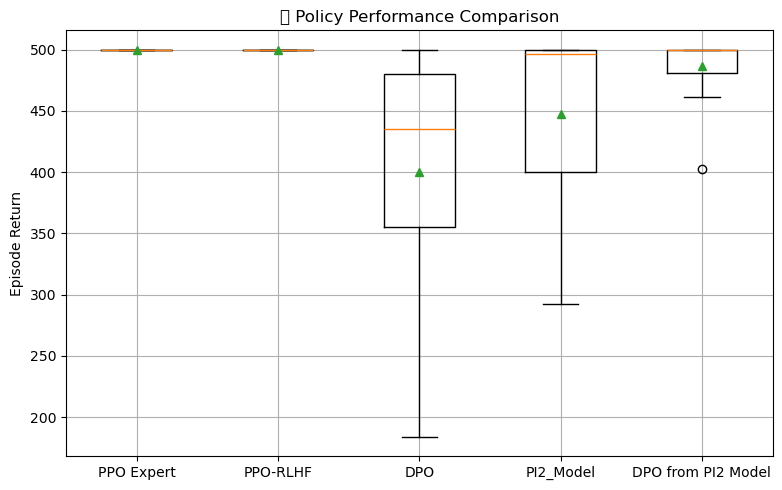

In [121]:
def eval_policy(model, env, is_sb3=True, episodes=20):
    returns = []
    for idx in range(episodes):
        obs, _ = env.reset(seed=idx)
        total = 0.0
        done = False
        while not done:
            action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        returns.append(total)
    return returns


env = gym.make(env_id)
returns_expert = eval_policy(PPO.load(f"{env_id}_expert_seed{seed}.zip", env=env), env)
returns_rlhf   = eval_policy(PPO.load(f"{env_id}_rlhf_seed{seed}.zip", env=env), env)
dpo_model = SharedPolicyNet(obs_dim, act_dim, is_discrete)
dpo_model.load_state_dict(torch.load(f"{env_id}_dpo_seed{seed}.pth"))
returns_dpo  = eval_policy(dpo_model, env, is_sb3=False)
returns_pi2 = eval_policy(PPO.load(f"{env_id}_pi2_model_seed{seed}.zip", env=env), env)
dpo_from_pi2 = SharedPolicyNet(obs_dim, act_dim, is_discrete)
dpo_from_pi2.load_state_dict(torch.load(f"{env_id}_dpo_pi2_seed{seed}.pth"))
returns_dpo_from_pi2 = eval_policy(dpo_from_pi2, env, is_sb3=False)


plt.figure(figsize=(8, 5))
plt.boxplot([returns_expert, returns_rlhf, returns_dpo, returns_pi2, returns_dpo_from_pi2],
            labels=["PPO Expert", "PPO-RLHF", "DPO", "PI2_Model", "DPO from PI2 Model"],
            showmeans=True)
plt.title("🎯 Policy Performance Comparison")
plt.ylabel("Episode Return")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{env_id}_benchmark_{seed}.png", dpi=300)
plt.show()



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


✅ GIF saved to: /Users/mathis/Master/RL/project/EE-568-RL/CartPole-v1_comparison_seed42.gif


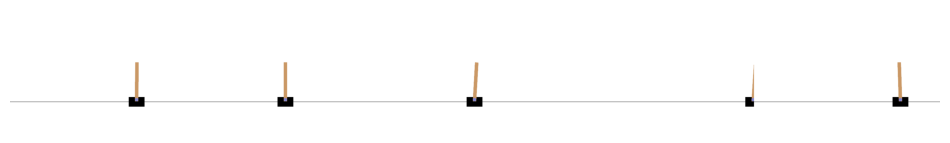

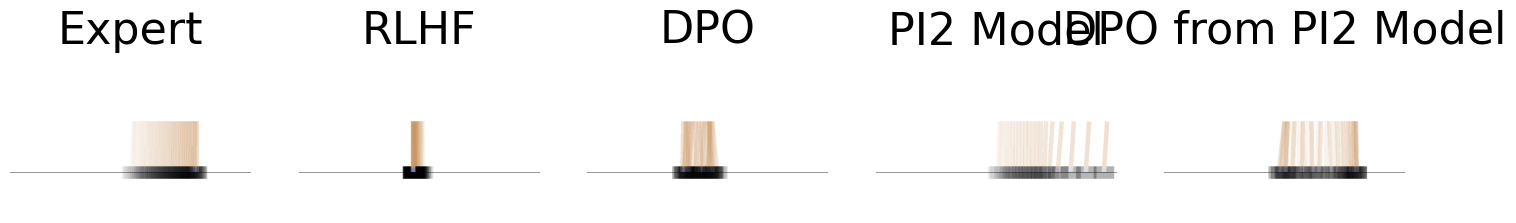

In [122]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from stable_baselines3 import PPO
import os

# Step 1: Run a single episode and record rendered frames
def record_episode(model, env, is_sb3=True, seed=None, max_steps=1000):
    frames = []
    obs, _ = env.reset(seed=seed)
    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)
        action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    env.close()
    return frames

# Step 2: Combine multiple frame sequences into a single animation and optionally save as a GIF
def show_combined_animation(frames_list, fps=30, gif_path=None):
    min_len = min(len(f) for f in frames_list)
    fig = plt.figure(figsize=(12, 4))
    plt.axis('off')
    init_frame = np.hstack([f[0] for f in frames_list])
    im = plt.imshow(init_frame)

    def update(i):
        combined = np.hstack([f[i] for f in frames_list])
        im.set_array(combined)
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=min_len, interval=1000/fps)

    if gif_path:
        ani.save(gif_path, writer='pillow', fps=fps)
        print(f"✅ GIF saved to: {os.path.abspath(gif_path)}")

    return HTML(ani.to_jshtml())

def trajectory_overlay_faded(frames, threshold=30, min_alpha=0.05, max_alpha=0.3):
    frames = [f.astype(np.float32) for f in frames]
    H, W, C = frames[0].shape

    overlay = np.ones((H, W, C), dtype=np.float32) * 255
    num_frames = len(frames)

    for idx, frame in enumerate(frames):
        diff = np.abs(frame - 255)
        mask = (diff.mean(axis=2) > threshold)

        alpha = min_alpha + (max_alpha - min_alpha) * (idx / (num_frames - 1))

        for c in range(3):
            overlay[:, :, c][mask] = (
                alpha * frame[:, :, c][mask] +
                (1 - alpha) * overlay[:, :, c][mask]
            )
    return np.clip(overlay, 0, 255).astype(np.uint8)

def show_trajectory_comparison(img_expert, img_rlhf, img_dpo, img_pi2, img_dpo_from_pi2, titles=None):
    if titles is None:
        titles = ["Expert", "RLHF", "DPO", "PI2 Model", "DPO from PI2 Model"]

    fig, axes = plt.subplots(1, 5, figsize=(18, 6))
    images = [img_expert, img_rlhf, img_dpo, img_pi2, img_dpo_from_pi2]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title, fontsize=32)
        ax.axis('off')



# Step 3: Load models and environments
env_expert = gym.make(env_id, render_mode="rgb_array")
env_rlhf   = gym.make(env_id, render_mode="rgb_array")
env_dpo    = gym.make(env_id, render_mode="rgb_array")
env_pi2 = gym.make(env_id, render_mode="rgb_array")
env_dpo_from_pi2 = gym.make(env_id, render_mode="rgb_array")
expert_model = PPO.load(f"{env_id}_expert_seed{seed}.zip", env=env_expert)
rlhf_model   = PPO.load(f"{env_id}_rlhf_seed{seed}.zip", env=env_rlhf)
dpo_model = SharedPolicyNet(obs_dim, act_dim, is_discrete)
dpo_model.load_state_dict(torch.load(f"{env_id}_dpo_seed{seed}.pth"))
pi2_model = PPO.load(f"{env_id}_pi2_model_seed{seed}.zip", env=env_pi2)
dpo_model_from_pi2 = SharedPolicyNet(obs_dim, act_dim, is_discrete)
dpo_model_from_pi2.load_state_dict(torch.load(f"{env_id}_dpo_pi2_seed{seed}.pth"))

# Step 4: Collect animation frames for all three strategies
frames_expert = record_episode(expert_model, env_expert, seed=seed)
frames_rlhf   = record_episode(rlhf_model, env_rlhf, seed=seed)
frames_dpo    = record_episode(dpo_model, env_dpo, is_sb3=False, seed=seed)
frames_pi2 = record_episode(pi2_model, env_pi2, seed=seed)
frames_dpo_from_pi2 = record_episode(dpo_model_from_pi2, env_dpo_from_pi2,is_sb3=False, seed=seed)

# Step 5: Display the combined animation and save it as a GIF file
display(HTML("<h3>🎯 Strategy Animation Comparison: PPO Expert vs RLHF vs DPO vs PI2 vs DPO_PI2</h3>"))
display(show_combined_animation(
    [frames_expert, frames_rlhf, frames_dpo, frames_pi2, frames_dpo_from_pi2],
    gif_path=f"{env_id}_comparison_seed{seed}.gif"
))

img_expert = trajectory_overlay_faded(frames_expert[::15], threshold=55)
img_rlhf = trajectory_overlay_faded(frames_rlhf[::15], threshold=55)
img_dpo = trajectory_overlay_faded(frames_dpo[::15], threshold=55)
img_pi2 = trajectory_overlay_faded(frames_pi2[::15], threshold=55)
img_dpo_from_pi2 = trajectory_overlay_faded(frames_dpo_from_pi2[::15], threshold=55)
show_trajectory_comparison(img_expert, img_rlhf, img_dpo, img_pi2, img_dpo_from_pi2)
